## Understanding PEDAP Dataset
This notebook tries provides details on the structure of the PEDAP dataset and makes suggestions how to process the data.

## The PEDAP study

**Title**: The Pediatric Artificial Pancreas (PEDAP) trial: A Randomized Controlled Comparison of the Control- IQ technology 
Versus Standard of Care in Young Children in Type 1 Diabetes


**Description**: The objective of the study is to assess efficacy, quality of life, and safety of a closed loop control (CLC) system (t:slim X2 with Control-IQ Technology) in a randomized controlled trial with partial crossover.
    
**Devices**: t:slim X2 with Control-IQ and Dexcom G6 system

**Study Population**: Children aged 2 - 5 years old

# Data
The study data folder is named **PEDAP Public Dataset - Release 1 - 2024-04-16**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Files** subfolder.

* **PEDAPTandemBOLUSDELIVERED.txt**: Event logged on pump when delivery of an insulin bolus (Standard, Extended, or Automatic) is completed
* **PEDAPTandemBASALRATECHG.txt**: Event logged on pump when insulin basal rate changes due to pumping events
* **PEDAPTandemCGMDataGXB.txt**: List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## PEDAPTandemBOLUSDELIVERED
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time of completion of bolus delivery
* **BolusAmount**: size of completed bolus
* **CarbAmount**: grams of carbs announced to the pump
* **BolusType**: The bolus insulin delivery type [Standard, Extended, Automatic]
* **Duration**: For extended boluses, the requested bolus duration in minutes
* **ExtendedBolusPortion**: Flag distinguishing the immediate (Now) portion of the bolus (if any) from the extended (Later) portion [Now, Later]
## PEDAPTandemBASALRATECHG
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time of basal rate change
* **BasalRate**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
## PEDAPTandemCGMDataGXB
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time 
* **CGMValue**: Value of CGM reading, in mg/dL; 0 indicates a below-range reading (<40) or above-range reading (>400)
* **HighLowIndicator**: Flag indicating presence of an in-range reading (0), below-range reading (2), or above-range reading (1)



## Questions
- Is the smaller number of unique patient ids in basal due to the algorithm used? Check patient Roster
- 

In [1]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

## Load the data

In [2]:
filepath = os.getcwd()
study_path = os.path.join(filepath, '../data/raw/PEDAP Public Dataset - Release 3 - 2024-09-25')

df_bolus = pd.read_csv(os.path.join(study_path, 'Data Files', 'PEDAPTandemBOLUSDELIVERED.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'BolusAmount', 'BolusType','CarbAmount','Duration','ExtendedBolusPortion'])
df_basal = pd.read_csv(os.path.join(study_path, 'Data Files', 'PEDAPTandemBASALRATECHG.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'BasalRate'])
df_cgm = pd.read_csv(os.path.join(study_path, 'Data Files', 'PEDAPTandemCGMDataGXB.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'CGMValue'])
df_patient = pd.read_csv(os.path.join(study_path, 'Data Files', 'PtRoster.txt'), sep="|")

## Inspecting the Data

In [3]:
print("CGM counts: " )
display(df_cgm.count())
print("Bolus counts: " )
display(df_bolus.count())
print("Basal counts: " )
display(df_basal.count())

print("unique CGM patient ids: ", len(df_cgm.PtID.unique()))
print("unique bolus patient ids: ", len(df_bolus.PtID.unique()))
print("unique basal patient ids: ", len(df_basal.PtID.unique()))


CGM counts: 


PtID          6623237
RecID         6623237
DeviceDtTm    6623237
CGMValue      6623237
dtype: int64

Bolus counts: 


PtID                    263080
RecID                   263076
DeviceDtTm              263076
BolusAmount             263076
CarbAmount              263080
BolusType               263080
Duration                263080
ExtendedBolusPortion     16868
dtype: int64

Basal counts: 


PtID          898874
RecID         898874
DeviceDtTm    898874
BasalRate     898874
dtype: int64

unique CGM patient ids:  99
unique bolus patient ids:  99
unique basal patient ids:  65


- ~6.5% extended boluses --> handle
- some mismatching counts for bolus (some nan values?) --> inspect
- many patients without basal data --> intersect the data

In [4]:
#drop all rows of patients not in all 3 datasets
intersecting_patient_ids = set(df_cgm.PtID.unique()).intersection(set(df_bolus.PtID.unique())).intersection(set(df_basal.PtID.unique()))
df_cgm = df_cgm[df_cgm.PtID.isin(intersecting_patient_ids)]
df_bolus = df_bolus[df_bolus.PtID.isin(intersecting_patient_ids)]
df_basal = df_basal[df_basal.PtID.isin(intersecting_patient_ids)]

### Duplicates & Missing Data
We see that there are many duplicated data points without additional information. Also, we see that some DateTime data is missing for the boluses. We also see that for manyu patients there is no basal data. For all these cases, we remove the data.

In [5]:
print()
print(f"There are {df_bolus.duplicated(subset=['PtID','DeviceDtTm','BolusAmount','CarbAmount','BolusType','Duration']).sum()} duplicated rows in the bolus dataset")
print(f"There are {df_basal.duplicated(subset=['PtID','DeviceDtTm','BasalRate']).sum()} duplicated rows in the basal dataset")
print(f"There are {df_cgm.duplicated(subset=['PtID','DeviceDtTm']).sum()} duplicated rows in the cgm dataset")
print()
print(f"There are {df_basal.DeviceDtTm.isna().sum()} missing values in the basal data")
print(f"There are {df_bolus.DeviceDtTm.isna().sum()} missing values in the bolus data")
print(f"There are {df_cgm.DeviceDtTm.isna().sum()} missing values in the cgm data")
print()

print("Example of duplicated rows in the basal dataset")
display(df_basal.loc[df_basal.duplicated(subset=['PtID','DeviceDtTm','BasalRate'], keep=False)].sort_values(by=['PtID','DeviceDtTm']).head(2))
print("Example of duplicated rows in the bolus dataset")
display(df_bolus.loc[df_bolus.duplicated(subset=['PtID','DeviceDtTm','BolusAmount','CarbAmount','BolusType','Duration'], keep=False)].sort_values(by=['PtID','DeviceDtTm']).head(2))
print("Example of duplicated rows in the cgm dataset")
display(df_cgm.loc[df_cgm.duplicated(subset=['PtID','DeviceDtTm'], keep=False)].sort_values(by=['PtID','DeviceDtTm']).head(2))

print()
print("Example of missing values in the bolus dataset")
display(df_bolus.loc[df_bolus.DeviceDtTm.isna()].head(2))


There are 0 duplicated rows in the bolus dataset
There are 75139 duplicated rows in the basal dataset
There are 677 duplicated rows in the cgm dataset

There are 0 missing values in the basal data
There are 3 missing values in the bolus data
There are 0 missing values in the cgm data

Example of duplicated rows in the basal dataset


,PtID,RecID,DeviceDtTm,BasalRate
5973,8,5986,1/1/2021 12:14:52 AM,0.0
5974,8,5987,1/1/2021 12:14:52 AM,0.0


Example of duplicated rows in the bolus dataset


,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion


Example of duplicated rows in the cgm dataset


,PtID,RecID,DeviceDtTm,CGMValue
1605944,3,1865679,10/31/2021 4:54:24 AM,126
1613058,3,1872793,10/31/2021 4:54:24 AM,126



Example of missing values in the bolus dataset


,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion
11873,4,NaN,NaN,NaN,0,Automatic,0,NaN
258932,40,NaN,NaN,NaN,27,Extended,120,Later


In [6]:
# remove duplicated rows
df_basal = df_basal.drop_duplicates(subset=['PtID','DeviceDtTm','BasalRate'])
df_bolus = df_bolus.drop_duplicates(subset=['PtID','DeviceDtTm','BolusAmount','CarbAmount','BolusType','Duration'])
df_cgm = df_cgm.drop_duplicates(subset=['PtID','DeviceDtTm'])
#remove missing DeviceDtTm for the bolus dataset
df_bolus = df_bolus.dropna(subset=['DeviceDtTm'])

## Parsing DateTimes
First, we check for datetime format:

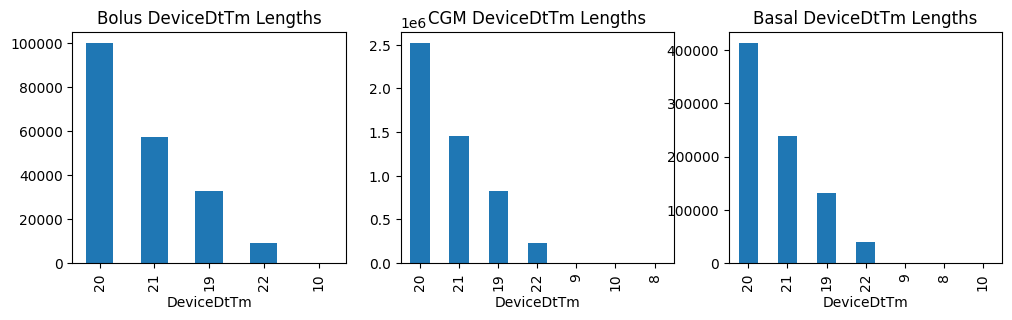

Example for 22 characters: 12/28/2020 10:04:21 PM
Example for 21 characters: 12/28/2020 1:26:18 PM
Example for 20 characters: 1/1/2021 12:03:19 AM
Example for 19 characters: 1/1/2021 1:03:12 AM
Example for 10 characters: 11/29/2020
Example for 9 characters: 12/1/2020
Example for 8 characters: 9/5/2020

Example for midnight datetime: 


,PtID,RecID,DeviceDtTm,BasalRate
155475,20,158975,9/4/2020 10:04:48 PM,1.250
155476,20,158976,9/4/2020 11:55:01 PM,0.239
155477,20,158977,9/5/2020,1.250
155478,20,158978,9/5/2020 12:05:00 AM,1.000
155479,20,158979,9/5/2020 12:24:58 AM,0.640


In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
df_bolus['DeviceDtTm'].str.len().value_counts().plot.bar(ax=axes[0], title='Bolus DeviceDtTm Lengths')
df_cgm['DeviceDtTm'].str.len().value_counts().plot.bar(ax=axes[1], title='CGM DeviceDtTm Lengths')
df_basal['DeviceDtTm'].str.len().value_counts().plot.bar(ax=axes[2], title='Basal DeviceDtTm Lengths')
plt.show()

print(f"Example for 22 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 22].iloc[0]}")  
print(f"Example for 21 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 21].iloc[0]}")
print(f"Example for 20 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 20].iloc[0]}")
print(f"Example for 19 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 19].iloc[0]}")
print(f"Example for 10 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 10].iloc[0]}")
print(f"Example for 9 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 9].iloc[0]}")
print(f"Example for 8 characters: {df_basal.DeviceDtTm[df_basal['DeviceDtTm'].str.len() == 8].iloc[0]}")

print()
temp = df_basal.index[df_basal['DeviceDtTm'].str.len() == 8][0]
print(f"Example for midnight datetime: ")
display(df_basal.loc[temp-2:temp+2])

In [8]:
def parse_flair_dates(dates):
    """Parse date strings separately for those with/without time component, interpret those without as midnight (00AM)
    Args:
        df (pandas DataFrame): data frame holding data date_column (string): 
        column name that holds date time strings to be used for parsing either in in the %m/%d/%Y or %m/%d/%Y %I:%M:%S %p format
    Returns:
        pandas series: with parsed dates
    """
    #make sure to only parse dates if the value is not null
    only_date = dates.apply(len) <=10
    dates_copy = dates.copy()
    dates_copy.loc[only_date] = pd.to_datetime(dates.loc[only_date], format='%m/%d/%Y')
    dates_copy.loc[~only_date] = pd.to_datetime(dates.loc[~only_date], format='%m/%d/%Y %I:%M:%S %p')
    return dates_copy

df_bolus['DeviceDtTm_parsed'] = parse_flair_dates(df_bolus['DeviceDtTm'])
df_cgm['DeviceDtTm_parsed'] = parse_flair_dates(df_cgm['DeviceDtTm'])
df_basal['DeviceDtTm_parsed'] = parse_flair_dates(df_basal['DeviceDtTm'])

lengths = [8, 9, 10, 19, 20, 21, 22]
for length in lengths:
    example_row = df_basal[df_basal['DeviceDtTm'].str.len() == 8].iloc[0]
    print(f"Example for {length} characters: {example_row['DeviceDtTm']} -> {example_row['DeviceDtTm_parsed']}")


Example for 8 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 9 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 10 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 19 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 20 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 21 characters: 9/5/2020 -> 2020-09-05 00:00:00
Example for 22 characters: 9/5/2020 -> 2020-09-05 00:00:00


### Drop Non-Tandem Patients (No Basal data)
We know that there are only 65 unique pt ids with basal data? This is because basal rate changes are only recorded for CLC (Tandem Control IQ) users while Standard Care (SC) group either is on MDI or a different pump system. We don't have information about the actual basal rates for these patients except for the screening form.

In [9]:
treatment_groups = df_patient.groupby('TrtGroup')
clc_pt_ids = treatment_groups.get_group('CLC').PtID.unique()

clc_w_basal = np.intersect1d(clc_pt_ids, df_basal.PtID.unique())
clc_w_bolus = np.intersect1d(clc_pt_ids, df_bolus.PtID.unique())
clc_bolus_percentage = len(clc_w_bolus) / len(clc_pt_ids) * 100
clc_basal_percentage = len(clc_w_basal) / len(clc_pt_ids) * 100
print(f"Percentage of CLC patient IDs with bolus data: {clc_bolus_percentage:.2f}%")
print(f"Percentage of CLC patient IDs with basal data: {clc_basal_percentage:.2f}%")

sc_pt_ids = treatment_groups.get_group('SC').PtID.unique()
sc_w_basal = np.intersect1d(sc_pt_ids, df_basal.PtID.unique())
sc_w_bolus = np.intersect1d(sc_pt_ids, df_bolus.PtID.unique())
sc_bolus_percentage = len(sc_w_bolus) / len(sc_pt_ids) * 100
sc_basal_percentage = len(sc_w_basal) / len(sc_pt_ids) * 100
print(f"Percentage of SC patient IDs with bolus data: {sc_bolus_percentage:.2f}%")
print(f"Percentage of SC patient IDs with basal data: {sc_basal_percentage:.2f}%")


Percentage of CLC patient IDs with bolus data: 95.59%
Percentage of CLC patient IDs with basal data: 95.59%
Percentage of SC patient IDs with bolus data: 0.00%
Percentage of SC patient IDs with basal data: 0.00%


In [10]:
#drop all SC patients
clc_pt_ids = df_patient.groupby('TrtGroup').get_group('CLC').PtID.unique()
print(len(clc_pt_ids))
#intersect with all other ids to remove patients that are not in all datasets
pt_ids_to_keep = set(clc_pt_ids).intersection(set(df_bolus.PtID.unique())).intersection(set(df_basal.PtID.unique())).intersection(set(df_cgm.PtID.unique()))

df_bolus = df_bolus[df_bolus.PtID.isin(pt_ids_to_keep)]
df_basal = df_basal[df_basal.PtID.isin(pt_ids_to_keep)]
df_cgm = df_cgm[df_cgm.PtID.isin(pt_ids_to_keep)]
df_patient = df_patient[df_patient.PtID.isin(pt_ids_to_keep)]

68


## extended boluses

<div class="alert alert-block alert-warning">
<b>Extended Boluses:</b> There are 16868 extended boluses (~6.4% of the boluses). We are given the duration the extended portion was delivered in minutes in the Duration column
</div>

In [11]:
extended_boluses = df_bolus[df_bolus.BolusType=='Extended']
display(extended_boluses.head())

print("ExtendedBolusPortion volues:")
print(extended_boluses.ExtendedBolusPortion.value_counts(),"\n")

later = extended_boluses[extended_boluses.ExtendedBolusPortion=='Later']
display(later.head())


,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion,DeviceDtTm_parsed
126,27,178.0,1/4/2021 5:34:59 PM,0.705,35,Extended,120,Now,2021-01-04 17:34:59
178,27,204.0,1/7/2021 3:09:20 PM,0.480,23,Extended,60,Now,2021-01-07 15:09:20
397,4,680.0,1/30/2021 5:32:43 PM,0.345,23,Extended,60,Now,2021-01-30 17:32:43
685,4,784.0,2/6/2021 5:15:13 PM,0.570,25,Extended,60,Now,2021-02-06 17:15:13
695,4,794.0,2/7/2021 6:39:47 PM,0.405,26,Extended,60,Now,2021-02-07 18:39:47


ExtendedBolusPortion volues:
ExtendedBolusPortion
Later    6631
Now      6460
Name: count, dtype: int64 



,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion,DeviceDtTm_parsed
254446,27,1.0,1/4/2021 7:35:04 PM,0.675,35,Extended,120,Later,2021-01-04 19:35:04
254447,27,2.0,1/7/2021 4:09:19 PM,0.480,23,Extended,60,Later,2021-01-07 16:09:19
254448,4,3.0,1/27/2021 6:56:58 PM,1.100,22,Extended,30,Later,2021-01-27 18:56:58
254449,4,5.0,1/28/2021 8:23:22 AM,1.200,27,Extended,20,Later,2021-01-28 08:23:22
254450,4,6.0,1/30/2021 6:32:42 PM,0.345,23,Extended,60,Later,2021-01-30 18:32:42


## Comments:
* 400 boluses (~4.6%) only have an extended portion
* The duration appears in both the 'Now' and 'Later' labels
* When BolusType == 'Extended' & ExtendedBolusPortion == 'Now' it should be treated as a standard bolus

In [12]:
display(df_basal.head())

print("overall data counts:")
print(df_basal.count(),"\n")
print("unique patient ids: ", len(df_basal.PtID.unique()))

,PtID,RecID,DeviceDtTm,BasalRate,DeviceDtTm_parsed
0,27,3,12/28/2020 1:26:18 PM,0.300,2020-12-28 13:26:18
1,27,4,12/28/2020 2:21:15 PM,0.000,2020-12-28 14:21:15
2,27,5,12/28/2020 2:26:14 PM,0.300,2020-12-28 14:26:14
3,27,6,12/28/2020 2:36:14 PM,0.151,2020-12-28 14:36:14
4,27,7,12/28/2020 2:41:32 PM,0.148,2020-12-28 14:41:32


overall data counts:
PtID                 823735
RecID                823735
DeviceDtTm           823735
BasalRate            823735
DeviceDtTm_parsed    823735
dtype: int64 

unique patient ids:  65
